# Computation of the spectral gap

### Introduction
As explained in the challenge description, the spectral gap of a Hermitian matrix (Hamiltonian) $H$ is the difference between the two lowest eigenvalues. For our computations we assume the two lowest eigenvalues to be different. We denote the lowest eigenvalue (the ground state) as $\lambda_0$ and the second lowest eigenvalue as $\lambda_1$.
The variational quantum eigensolver (VQE) uses the variational principle, which states that 
$$ \lambda_0 \leq \langle \psi| H |\psi \rangle \quad \text{for every quantum state } |\psi\rangle.$$
We express the quantum state $|\psi \rangle$ as $|\psi\rangle = U(\theta)|0\rangle$, where $U(\theta)$ is a parametrized unitary (the *ansatz*) that can be implemented on a quantum computer. The VQE aims at solving the optimization problem
$$ \lambda_0 = \min_\theta \langle 0| U^\dagger(\theta) H U(\theta) |0 \rangle  .$$

In our project, we compute the ground state with the VQE. That is, we compute parameters $\theta_*$ such that $\langle 0| U^\dagger(\theta_*) H U(\theta_*) |0 \rangle$ becomes minimal. The quantum state $|\psi_0\rangle = U(\theta_*)|0\rangle$ is the corresponding eigenvector of the ground state.

To compute the second lowest eigenvalue, we use the fact that for Hermitian matrices, eigenspaces of different eigenvalues are orthogonal.
The variational principle ensures that 
$$ \lambda_1 \leq \langle \psi| H |\psi \rangle \quad \text{for every quantum state } |\psi\rangle \text{ in the orthogonal complement of } |\psi_0\rangle. $$

If we can ensure that the ansatz of the VQE generates only states that are in the orthogonal complement of the ground state eigenvector, we can approximate the second lowest eigenvalue. 
[1] gives some examples for such ansätze. However, these ansätze are either adapted to specific problems or involve time-evolving a Hamiltonian.
In our project, we provide an ansatz that is easy to implement but is also general enough to be applicable for different problems.


[1] Sherbert, Kyle, and Marco Buongiorno Nardelli. "Orthogonal-ansatz VQE: Locating excited states without modifying a cost-function." arXiv preprint arXiv:2204.04361 (2022).

## Idea

Our idea is to adapt a general hardware-efficient ansatz such that this new ansatz fulfils the requirements explained above.
We denote the ansatz as $U$ and look at an example of 3 qubits to explain the idea.
For now let's assume that the eigenvector of the ground state is $|000\rangle$. The graphic below shows our ansatz. 

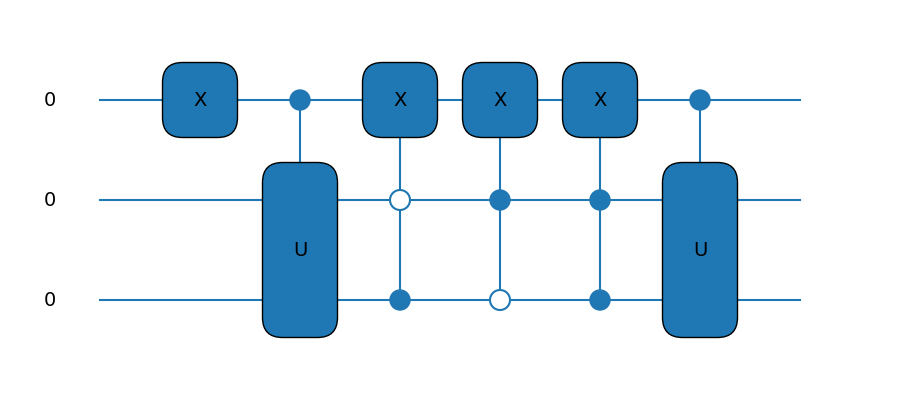

Let's assume that $U(\theta)$ maps the state 
$|00\rangle$ to $U(\theta)|00\rangle = a|00\rangle + b|01\rangle + c|10\rangle + d|11\rangle$ (where $a,b,c,d \in \mathbb{C}).$
Then, after controlled $U$ has been applied, the quantum state is $$ (U(\theta)|00\rangle)|1\rangle = a|001\rangle + b|011\rangle + c|101\rangle + d|111\rangle.$$ Applying the multi-controlled X gates gives us $$a|001\rangle + b|010\rangle + c|100\rangle + d|110\rangle.$$ Now we apply the ansatz $U$ again (but with different parameters $\theta'$, that is, $U(\theta') = e|00\rangle + f|01\rangle + g|10\rangle + h|11\rangle$ for $e,f,g,h \in \mathbb{C})$ and obtain
$$ ae|001\rangle + af|011\rangle + ag|101\rangle + ah|111\rangle + b|010\rangle + c|100\rangle + d|110\rangle.$$
This state is orthogonal to $|000\rangle$. By optimizing the parameters accordingly, we can search (approximately) the whole orthogonal complement of $|000\rangle$ to find the second lowest eigenvalue and the corresponding eigenvector.

If the eigenvector of the ground state is not $|000\rangle$, one has to perform a basis transformation. If the ground state has been computed beforehand with the VQE with the ansatz $V$, the state $V(\theta_*) = |\psi_0\rangle$ approximates the eigenvector of the ground state (with $\theta_*$ being the optimized parameter). We can map the state $|\psi_0\rangle$ to the state $|000\rangle$ by applying the inverse of $V(\theta_*)$ (that is $V^\dagger(\theta_*)$) to $|\psi\rangle$. After that we apply our previously explained ansatz to $|000\rangle$ which results in a state that is in the orthogonal complement of $|000\rangle$. Since unitary matrices (such as $V(\theta_*)$) map orthonormal bases to orthonormal bases,  applying $V(\theta_*)$ maps the orthogonal complement of $|000\rangle$ to the orthogonal complement of $|\psi_0\rangle$. 

To summarize, the following steps have to be performed to compute the spectral gap of a given Hamiltonian:
- compute the ground state with the VQE with the ansatz $V$ and store the optimized parameter $\theta_*$
- compute the excited state with the VQE with the ansatz described below:
    - The initial state is $|0 ... 0\rangle$
    - Apply $V^\dagger(\theta_*)$
    - Apply the controlled ansatz $U$ twice, with multicontrolled X gates in-between (as described above)
    - Apply $V(\theta_*)$
- compute the difference of the ground state and excited state

Note that the ansatz $V$ and $U$ do not have to have the same circuit architecture.

### Generalization and optimization of the circuit

Let $n+1$ be the number of qubits in a circuit. We denote a computational basis state with $|q_n ... q_0\rangle$ or $|q_n \dots q_1\rangle|q_0\rangle$ (depending on the context), where $q_0, \dots, q_n \in \{0,1\}$.
The idea behind using the multi-controlled X gates between the controlled ansätze is to leave the state $|0\dots0\rangle|1\rangle$ untouched and to swap the state of the qubit $q_0$ if at least one $q_i=1$ for $i=1, \dots, n$.
More precisely, after applying the first controlled ansatz we have the state $(U |0 \dots 0\rangle )|1\rangle$. Depending on the parameters this state can be in a superposition of $|0 \dots 0 \rangle |1\rangle, \dots, |1 \dots 1 \rangle |1\rangle$, but the amplitudes of the computational basis states with $q_0 = 0$ are zero.
After applying the multi-controlled $X$ gates we have a superposition of the states $|0 \dots 0 \rangle |1\rangle, |0 \dots 0\rangle |0\rangle, \dots, |1 \dots 1 \rangle |0\rangle$. The state $|0 \dots 0 \rangle |1\rangle$ is the only state with $q_0=1$ and applying the controlled ansatz again gives us a superposition of all computational basis states except $|0 \dots 0\rangle$.

What the operation of the multicontrolled $X$ gates does is basically an OR operation of the qubits $q_1, ..., q_n$, i.e.
$$ \text{sequence of multicontrolled-X } |q_n \dots q_1\rangle |0\rangle = |q_n \dots q_1\rangle |q_n \text{ OR } \dots \text{ OR } q_1\rangle.$$
Implementing this directly in a quantum circuit is very inefficient since the number of controlled $X$ gates increases exponentially with the number of qubits (for $n+1$ qubits we need $2^n -1$ multicontrolled $X$ gates). However, by applying De Morgan's laws we see that
$$ q_n \text{ OR } \dots \text{ OR } q_1 = \neg ( \neg q_n \text{ AND } \dots \text{ AND } \neg q_1).$$
Implementing the second term requires only one multicontrolled-$X$ gate and $2n$ $X$ gates.

Another aspect for potential optimization is the possibility of the usage of different ansätze when computing the ground state and excited state. For example one could use a chemistry-inspired ansatz to compute the ground state and to perform the basis transformation in the circuit for the excited state, while using a hardware-efficient ansatz for computing the excited state.

## Experiments

We perform experiments on a custom defined Hamiltonian first to test our ideas.

### Example with $|000\rangle$ as ground state eigenvector

In [298]:
import pennylane as qml
from pennylane import numpy as np
import matplotlib.pyplot as plt


In [287]:
obs = qml.Hermitian(np.diag([-8,2,5,1,0,-4,6,7]), wires=range(3))
H = qml.Hamiltonian((1, ), (obs, ))

In [288]:
# ansatz for finding the second lowest eigenvalue
dev = qml.device('default.qubit', wires=3)

def ctrlU(params):
    qml.CRY(params[0], wires=[0,1])
    qml.CRY(params[1], wires=[0,2])
    qml.CRZ(params[2], wires=[0,1])
    qml.CRZ(params[3], wires=[0,2])
    qml.Toffoli(wires=[0,1,2]) 
    qml.CRY(params[4], wires=[0,1])
    qml.CRY(params[5], wires=[0,2])
    qml.CRZ(params[6], wires=[0,1])
    qml.CRZ(params[7], wires=[0,2])

@qml.qnode(dev)
def ansatz(params, hamiltonian):
    
    qml.PauliX(wires=0)
    
    ctrlU(params[0:8])

    qml.MultiControlledX(wires=[1, 2, 0], control_values='01')
    qml.MultiControlledX(wires=[1, 2, 0], control_values='10')
    qml.MultiControlledX(wires=[1, 2, 0], control_values='11')

    ctrlU(params[8:16])
    
    return qml.expval(hamiltonian)



#### Visualization of the ansatz withouth basis transformation.
The sequence of multicontrolled-X gates is implemented more efficiently in later sections.

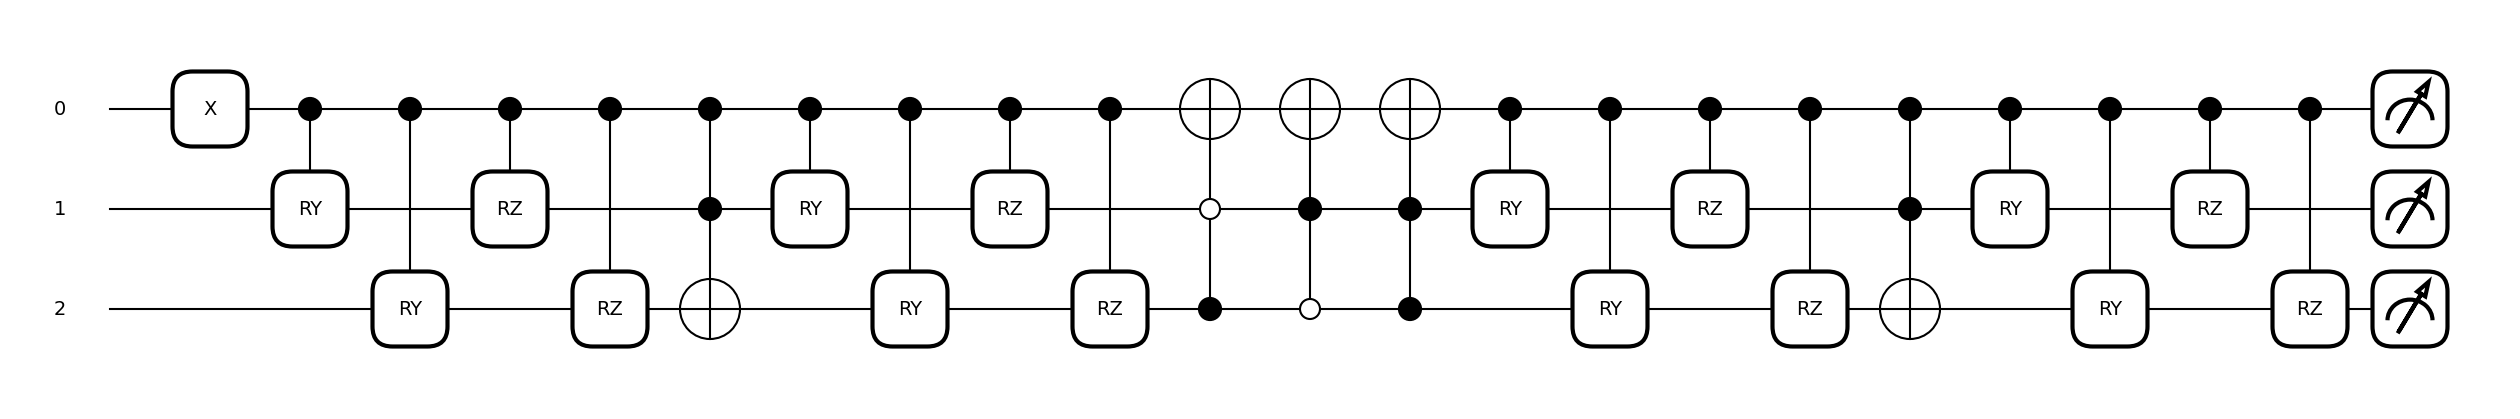

In [392]:
fig, ax = qml.draw_mpl(ansatz)(np.ones(16), H)
plt.savefig("ansatz_experiment_wo_basis_trafo.png")

In [299]:
def cost(params):
    return ansatz(params, H)

max_iterations = 500
conv_tol = 1e-06
opt = qml.AdamOptimizer()
NUM_PARAMETERS = 16

np.random.seed(0) # set the seed to 0 to reproduce the results
theta = np.random.random(NUM_PARAMETERS)

energy = [cost(theta)]

angle = [theta]

for n in range(max_iterations):
    theta, prev_cost = opt.step_and_cost(cost, theta)
    energy.append(cost(theta))
    angle.append(theta)

    conv = np.abs(energy[-1] - prev_cost)
    #print(energy[-1])

    if conv <= conv_tol:
        break

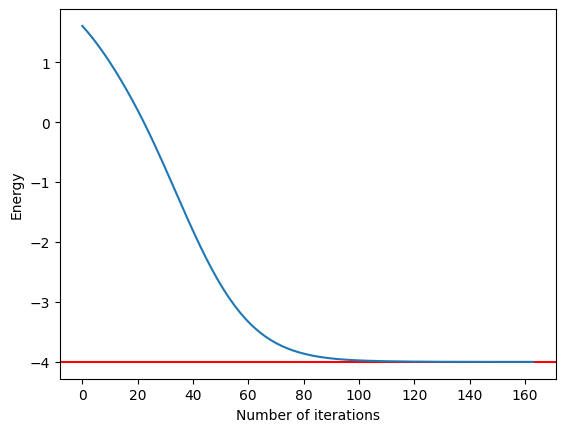

In [301]:
plt.axhline(y=-4, color='r', linestyle='-')
plt.plot(range(len(energy)), energy)
plt.xlabel("Number of iterations")
plt.ylabel("Energy")
plt.show()

### Example with basis transformation

#### Compute ground state first

In [378]:
# Hamiltonian has lowest eigenvalue not at 000, but at 001
obs = qml.Hermitian(np.diag([-8,-12,5,1,-10,-4,6,0]), wires=range(3))
H = qml.Hamiltonian((1, ), (obs, ))

In [379]:
#dev = qml.device('default.qubit', wires=3)

def ansatz_gates(params):
    qml.RY(params[0], wires=0)
    qml.RY(params[1], wires=1)
    qml.RY(params[2], wires=2)
    qml.RZ(params[3], wires=0)
    qml.RZ(params[4], wires=1)
    qml.RZ(params[5], wires=2)

    #qml.Barrier()
        
    qml.CNOT(wires=[0,1])
    qml.CNOT(wires=[1,2])

    #qml.Barrier()
    
    qml.RY(params[6], wires=0)
    qml.RY(params[7], wires=1)
    qml.RY(params[8], wires=2)
    qml.RZ(params[9], wires=0)
    qml.RZ(params[10], wires=1)
    qml.RZ(params[11], wires=2)

@qml.qnode(dev)
def ansatz_groundstate(params, hamiltonian):
    ansatz_gates(params)  
    return qml.expval(hamiltonian)

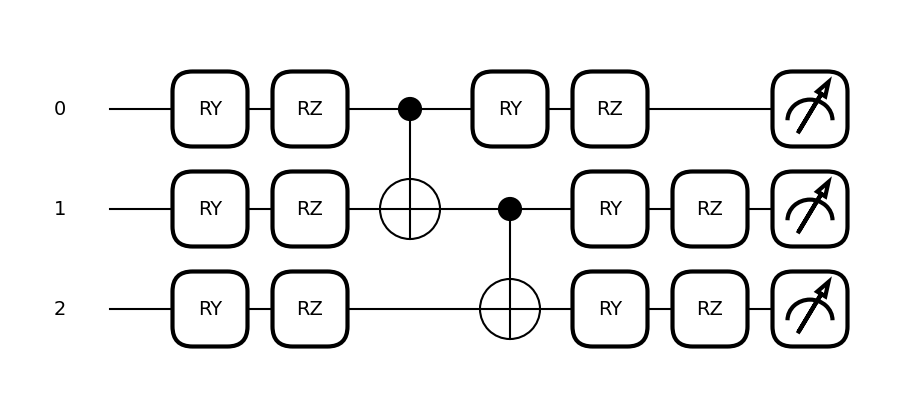

In [380]:
fig, ax = qml.draw_mpl(ansatz_groundstate)(np.zeros(12), H)

In [381]:
def cost(params):
    return ansatz_groundstate(params, H)

max_iterations = 500
conv_tol = 1e-06
opt = qml.AdamOptimizer()
NUM_PARAMETERS = 12
theta = np.random.random(NUM_PARAMETERS)
energy = [cost(theta)]

angle = [theta]

for n in range(max_iterations):
    theta, prev_cost = opt.step_and_cost(cost, theta)
    energy.append(cost(theta))
    angle.append(theta)

    conv = np.abs(energy[-1] - prev_cost)
    #print(energy[-1])

    if conv <= conv_tol:
        break

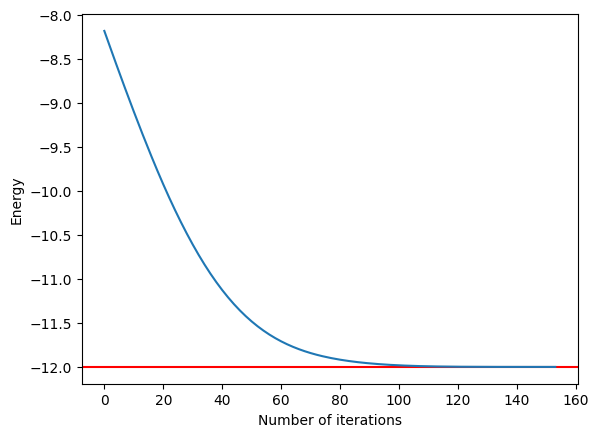

In [382]:
plt.axhline(y=-12, color='r', linestyle='-')
plt.plot(range(len(energy)), energy)
plt.xlabel("Number of iterations")
plt.ylabel("Energy")
plt.show()

<BarContainer object of 8 artists>

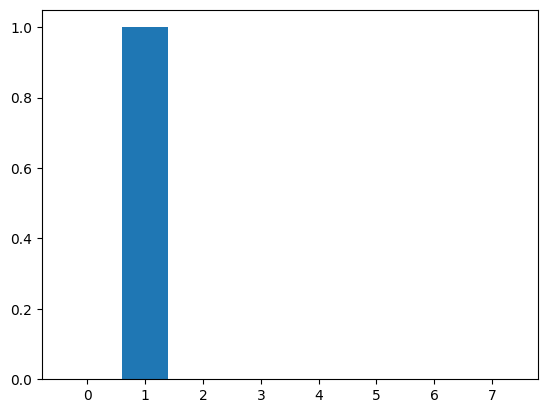

In [383]:
# Check if eigenvector of the ground state has been computed correctly 

@qml.qnode(dev)
def compute_eigenvector(params, hamiltonian):
    ansatz_gates(params)  
    return qml.probs(wires=range(3))

plt.bar(range(8), compute_eigenvector(angle[-1], H))

#### Compute excited state

In [384]:
# use previous results
result_params = angle[-1]

In [385]:
@qml.qnode(dev)
def ansatz_excited(params, hamiltonian):
    qml.adjoint(ansatz_gates)(result_params) #this unitary maps the eigenvector to |000>
    
    qml.PauliX(wires=0)
    
    ctrlU(params[0:8])
    
    qml.MultiControlledX(wires=[1, 2, 0], control_values='01')
    qml.MultiControlledX(wires=[1, 2, 0], control_values='10')
    qml.MultiControlledX(wires=[1, 2, 0], control_values='11')

    ctrlU(params[8:16])
    ansatz_gates(result_params)
    return qml.expval(hamiltonian)

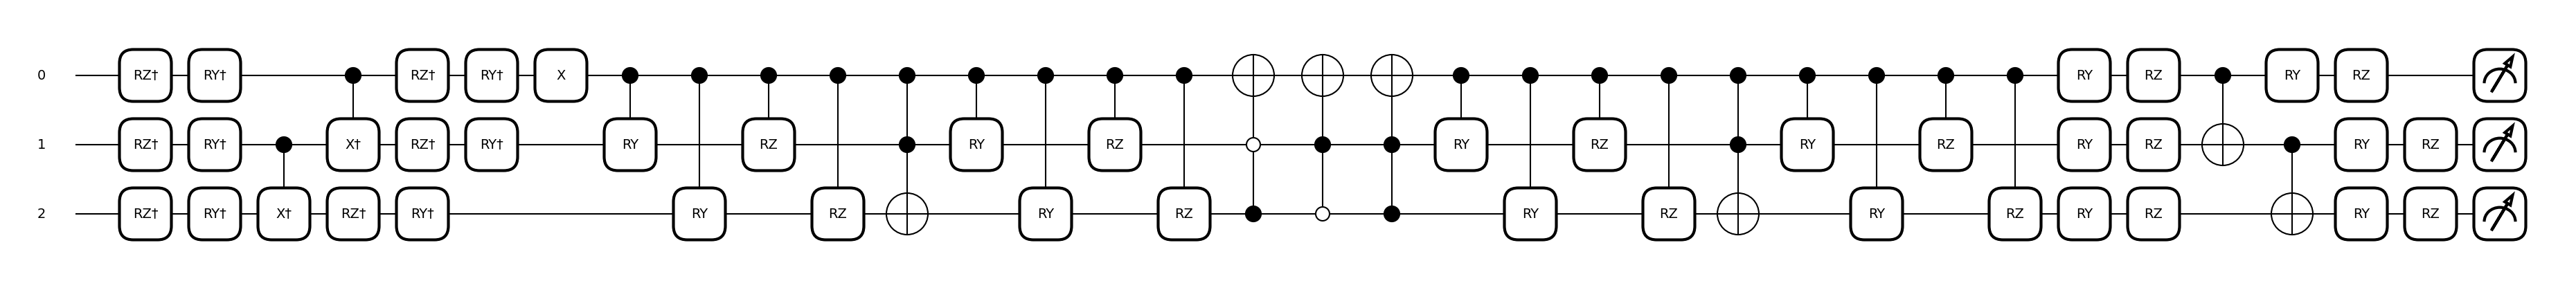

In [395]:
fig, ax = qml.draw_mpl(ansatz_excited)(np.zeros(16), H)
plt.savefig("ansatz_with_basis_trafo.png")

In [387]:
def cost(params):
    return ansatz_excited(params, H)

max_iterations = 500
conv_tol = 1e-06
opt = qml.AdamOptimizer()
NUM_PARAMETERS = 16

np.random.seed(0) # set the seed to 0 to reproduce the results
theta = np.random.random(NUM_PARAMETERS)
# store the values of the cost function
energy = [cost(theta)]

# store the values of the circuit parameter
angle = [theta]

for n in range(max_iterations):
    theta, prev_cost = opt.step_and_cost(cost, theta)
    energy.append(cost(theta))
    angle.append(theta)

    conv = np.abs(energy[-1] - prev_cost)
    #print(energy[-1])

    if conv <= conv_tol:
        break

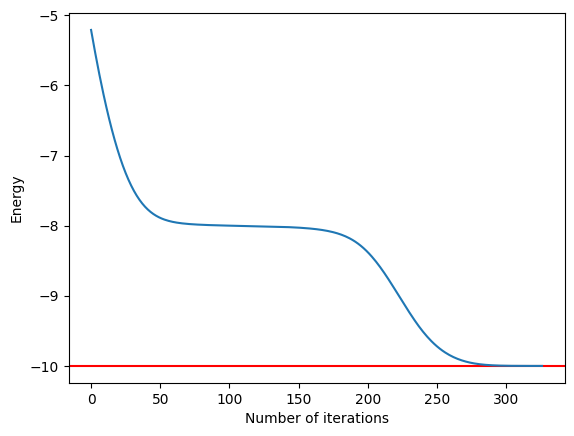

In [388]:
# adams optimizer
plt.axhline(y=-10, color='r', linestyle='-')
plt.plot(range(len(energy)), energy)
plt.xlabel("Number of iterations")
plt.ylabel("Energy")
plt.show()

## Visualization helper

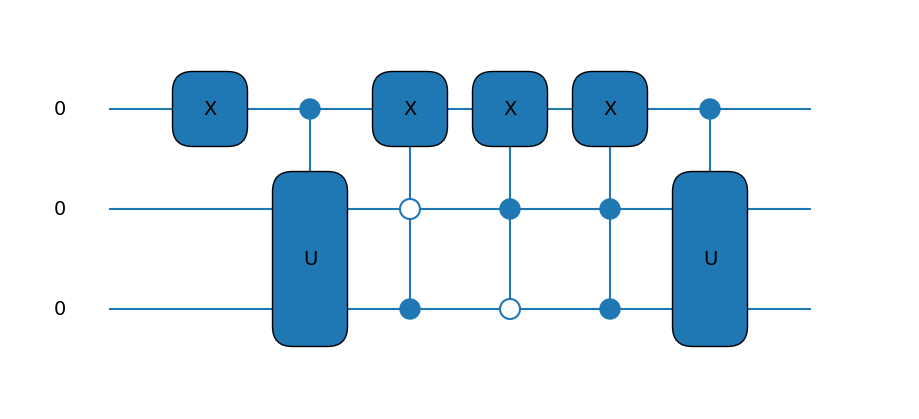

In [391]:
drawer = qml.drawer.MPLDrawer(n_wires=3, n_layers=6)

drawer.label(["0", "0", "0"])
index = 0
drawer.box_gate(layer=index, wires=0, text="X")

index += 1
drawer.ctrl(layer=index, wires=[0, 1], control_values=[True, False])
drawer.box_gate(
    layer=index, wires=[1,2], text="U", box_options={"zorder": 4}, text_options={"zorder": 5}
)

#drawer.box_gate(layer=1, wires=1, text="X")
#drawer.box_gate(layer=1, wires=2, text="X")
index += 1
drawer.ctrl(layer=index, wires=[0, 1, 2], control_values=[False, False, True])
drawer.box_gate(
    layer=index, wires=0, text="X", box_options={"zorder": 4}, text_options={"zorder": 5}
)

index += 1
drawer.ctrl(layer=index, wires=[0, 1, 2], control_values=[False, True, False])
drawer.box_gate(
    layer=index, wires=0, text="X", box_options={"zorder": 4}, text_options={"zorder": 5}
)

index += 1
drawer.ctrl(layer=index, wires=[0, 1, 2], control_values=[False, True, True])
drawer.box_gate(
    layer=index, wires=0, text="X", box_options={"zorder": 4}, text_options={"zorder": 5}
)
#drawer.box_gate(layer=3, wires=1, text="X")
#drawer.box_gate(layer=3, wires=2, text="X")

index += 1
drawer.ctrl(layer=index, wires=[0, 1], control_values=[True, False])
drawer.box_gate(
    layer=index, wires=[1,2], text="U", box_options={"zorder": 4}, text_options={"zorder": 5}
)

plt.savefig("ansatz.png")